### Load Model From Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
file_path ='/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/Test Config/model.h5'

In [ ]:
reconstructed_model = keras.models.load_model(file_path)


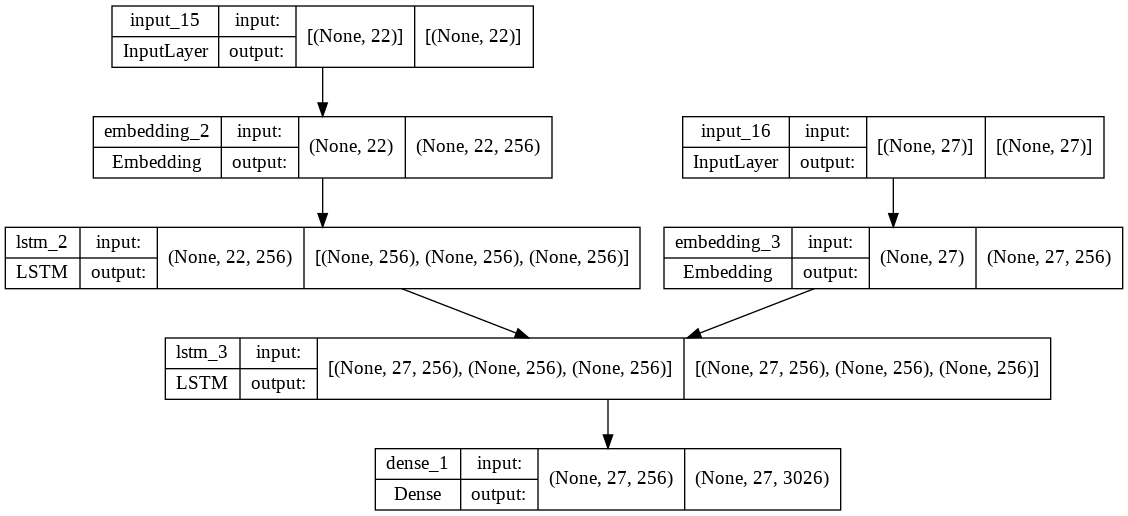

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)

In [ ]:
reconstructed_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 22)]         0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 27)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 22, 256)      614912      ['input_15[0][0]']               
                                                                                                  
 embedding_3 (Embedding)        (None, 27, 256)      774656      ['input_16[0][0]']               
                                                                                           

### Load Dictionaries and Parameters

In [ ]:
import pickle


path_encoder_parameters='/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/Test Config/encoder_parameters.pickle'
path_encoder_dictionary='/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/Test Config/encoder_dictionary.pickle'
path_decoder_parameters='/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/Test Config/decoder_parameters.pickle'
path_decoder_dictionary='/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/Test Config/decoder_dictionary.pickle'

# loading
with open(path_encoder_parameters, 'rb') as handle:
    encoder_parameters = pickle.load(handle)

# loading
with open(path_encoder_dictionary, 'rb') as handle:
    encoder_dictionary = pickle.load(handle)

# loading
with open(path_decoder_parameters, 'rb') as handle:
    decoder_parameters= pickle.load(handle)

# loading
with open(path_decoder_dictionary, 'rb') as handle:
    decoder_dictionary = pickle.load(handle)    


In [ ]:
print(encoder_parameters)
# encoder_dictionary
print(decoder_parameters)
# decoder_dictionary

{'max_encoder_seq_length': 22, 'num_encoder_tokens': 2402}
{'max_decoder_seq_length': 27, 'num_decoder_tokens': 3026}


In [ ]:
encoder_inputs = reconstructed_model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
latent_dim = 256  # Note: may be need to save in drive as well


In [ ]:
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras import layers , activations , models , preprocessing , utils


In [ ]:
num_hindi_tokens =decoder_parameters['num_decoder_tokens']
max_output_length= decoder_parameters['max_decoder_seq_length']
max_input_length= encoder_parameters['max_encoder_seq_length']

eng_word_dict=encoder_dictionary
hindi_word_dict= decoder_dictionary

In [ ]:

decoder_inputs = Input(shape=( max_output_length , ))
decoder_embedding = Embedding( num_hindi_tokens, 256 , mask_zero=True) (decoder_inputs)

decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_dense = Dense( num_hindi_tokens , activation=tf.keras.activations.softmax ) 


In [ ]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
          # print("word ", word, eng_word_dict.get(word,1) )
          my_word=  eng_word_dict.get(word,1)
          tokens_list.append(my_word) 
  
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')


In [ ]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


In [ ]:
enc_model , dec_model = make_inference_models()

## Test Previous Model
Maybe we dont nedd the make infernece model and its attributes (above)

In [ ]:
from tensorflow.keras.models import load_model


encoderPath="/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/Test Config/enc_model.h5" 
decoderPath="/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/Test Config/dec_model.h5"

# loading

enc_model =  load_model(encoderPath)


dec_model  =  load_model(decoderPath)

In [ ]:
import numpy as np

In [ ]:
for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens("I want to sleep" ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = hindi_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in hindi_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print("Decoded Traslation ", decoded_translation )
    # print(f"{bcolors.OKGREEN}Decoded Traslation: { decoded_translation}{bcolors.ENDC}")


Decoded Traslation   मैं तुमसे प्यार कर रहा हूँ। end


# BLEU Score

### Import Library

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

### Import Train Data: 
#### Calculte BLEU score on train data

Function to Translate English to Hindi

In [ ]:
def translate_sentence(sentence):
  for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens(sentence ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = hindi_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in hindi_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print("Decoded Traslation ", decoded_translation )
  return  decoded_translation

Import Data 

In [ ]:
!wget http://www.manythings.org/anki/hin-eng.zip -O hin-eng.zip
## IIT dataset : https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel.zip
!unzip hin-eng.zip

lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
lines.reset_index( level=0 , inplace=True )
lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
lines = lines.drop( 'c' , 1 )



--2022-08-28 13:41:25--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132114 (129K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 129.02K   796KB/s    in 0.2s    

2022-08-28 13:41:26 (796 KB/s) - ‘hin-eng.zip’ saved [132114/132114]

Archive:  hin-eng.zip
replace hin.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
lines.tail()

,eng,hindi
2910,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2911,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2912,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2913,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2914,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."


In [ ]:
sample_sentences= lines[-10:]
sample_sentences

,eng,hindi
2905,Mother Teresa was a Catholic nun who lived and...,मदर टेरेसा एक कैथोलिक नन थीं जो कलकत्ता में रह...
2906,George Washington was the first president of t...,जार्ज वाशिंगटन संयुक्त राज्य अमेरिका के पहले र...
2907,"From my point of view, Australia is one of the...",मेरे नज़रिए से ऑस्ट्रेलिया विश्व के सर्व-श्रेष...
2908,"In 1951, Sister Teresa was sent to Calcutta, t...","१९५१ में सिस्टर टेरेसा को कलकत्ता भेजा गया था,..."
2909,Mother Teresa used the prize money for her wor...,"मदर टेरेसा को जो इनाम में पैसे मिले, उन्होंने ..."
2910,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2911,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2912,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2913,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2914,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."


In [ ]:
sample_sentences.index

RangeIndex(start=2905, stop=2915, step=1)

### Reference Tokens

In [ ]:
reference_tokens=[]

for line in sample_sentences['hindi']:
   print( line.split() ) 
   reference_tokens.append( line.split() )

['मदर', 'टेरेसा', 'एक', 'कैथोलिक', 'नन', 'थीं', 'जो', 'कलकत्ता', 'में', 'रहतीं', 'और', 'काम', 'करतीं', 'थीं।']
['जार्ज', 'वाशिंगटन', 'संयुक्त', 'राज्य', 'अमेरिका', 'के', 'पहले', 'राष्ट्रपति', 'थे']
['मेरे', 'नज़रिए', 'से', 'ऑस्ट्रेलिया', 'विश्व', 'के', 'सर्व-श्रेष्ठ', 'देशों', 'में', 'से', 'एक', 'है।']
['१९५१', 'में', 'सिस्टर', 'टेरेसा', 'को', 'कलकत्ता', 'भेजा', 'गया', 'था,', 'जो', 'उस', 'समय', 'भारत', 'का', 'सबसे', 'बड़ा', 'शहर', 'था।']
['मदर', 'टेरेसा', 'को', 'जो', 'इनाम', 'में', 'पैसे', 'मिले,', 'उन्होंने', 'उन', 'पैसों', 'को', 'भारत', 'और', 'विदोश', 'दोनों', 'में', 'अपने', 'काम', 'में', 'लगाया।']
['उस', 'सूपरमार्केट', 'में', 'तुम', 'लगभग', 'कोई', 'भी', 'रोजाने', 'में', 'इस्तेमाल', 'होने', 'वाला', 'सामान', 'ख़रीद', 'सकते', 'हो।']
['जिन', 'यात्रियों', 'को', 'दुर्घटना', 'मे', 'चोट', 'आई', 'थी', 'उन्हे', 'अस्पताल', 'ले', 'जाया', 'गया।']
['लोकतंत्र', 'सरकार', 'का', 'सबसे', 'घिनौना', 'रूप', 'है,', 'अगर', 'बाकी', 'सारी', 'तरह', 'की', 'सरकारों', 'को', 'अंदेखा', 'किया', 'जाए', 'तो।']
['अगर'

In [ ]:
df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

df["reference"]= reference_tokens

df

,reference,candidate,bleu_score
0,"[मदर, टेरेसा, एक, कैथोलिक, नन, थीं, जो, कलकत्त...",NaN,NaN
1,"[जार्ज, वाशिंगटन, संयुक्त, राज्य, अमेरिका, के,...",NaN,NaN
2,"[मेरे, नज़रिए, से, ऑस्ट्रेलिया, विश्व, के, सर्...",NaN,NaN
3,"[१९५१, में, सिस्टर, टेरेसा, को, कलकत्ता, भेजा,...",NaN,NaN
4,"[मदर, टेरेसा, को, जो, इनाम, में, पैसे, मिले,, ...",NaN,NaN
5,"[उस, सूपरमार्केट, में, तुम, लगभग, कोई, भी, रोज...",NaN,NaN
6,"[जिन, यात्रियों, को, दुर्घटना, मे, चोट, आई, थी...",NaN,NaN
7,"[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, है,, ...",NaN,NaN
8,"[अगर, मेरा, बेटा, ट्रेफ़िक, हादसे, में, नहीं, ...",NaN,NaN
9,"[जब, मैं, बच्चा, था,, मुझे, कीड़ों, को, छूने, ...",NaN,NaN


### Candidate Tokens

In [ ]:
candidate_tokens=[]


for line in sample_sentences['eng']:
   
   result= translate_sentence(line)
   temp =result.split()
   temp= temp[:-1]
   candidate_tokens.append(temp)
   

df["candidate"]= candidate_tokens

df

Decoded Traslation   उस लड़की ने उसे पहले पहले पहले पहले पहले पहले पहले पहले पहले कम से कम उत्तर न जाएं। end
Decoded Traslation   मातापिता अपने बच्चों के मुताबिक भारत में बीमारों का सबसे बड़ा कर देगी। end
Decoded Traslation   मेरे पिता ने पिछले साल के लिए बहुत सारे पैसे छोड़े थे। end
Decoded Traslation   मातापिता अपने सारे घरवालों की सारी बत्तियाँ बंद कर सकते हैं end
Decoded Traslation   मदर टेरेसा को ढूँढने में से कम से कम से कम से कम से भारत में कुछ भी काम करना चाहता था। end
Decoded Traslation   अगर तुम उस दिन में उस समय में काम करने के लिए कितना समय नहीं कर सकते हो end
Decoded Traslation   मछवारे ने पकड़ी हुई पत्तियों को गिरते हुए पकड़ा end
Decoded Traslation   लोकतंत्र सरकार का सबसे घिनौना रूप से पहले भारत में तो बहुत सारी संपत्ति होती है। end
Decoded Traslation   अगर उसके जूते इतने खट्टे हैं कि वह जल्द से जल्द चुकताऊँगा। end
Decoded Traslation   मैं तुम्हें स्टेशन तक मैं उससे पहले कई बार आएगा मैं कसम भी हो तो मैं भूल गया। end


,reference,candidate,bleu_score
0,"[मदर, टेरेसा, एक, कैथोलिक, नन, थीं, जो, कलकत्त...","[उस, लड़की, ने, उसे, पहले, पहले, पहले, पहले, प...",NaN
1,"[जार्ज, वाशिंगटन, संयुक्त, राज्य, अमेरिका, के,...","[मातापिता, अपने, बच्चों, के, मुताबिक, भारत, मे...",NaN
2,"[मेरे, नज़रिए, से, ऑस्ट्रेलिया, विश्व, के, सर्...","[मेरे, पिता, ने, पिछले, साल, के, लिए, बहुत, सा...",NaN
3,"[१९५१, में, सिस्टर, टेरेसा, को, कलकत्ता, भेजा,...","[मातापिता, अपने, सारे, घरवालों, की, सारी, बत्त...",NaN
4,"[मदर, टेरेसा, को, जो, इनाम, में, पैसे, मिले,, ...","[मदर, टेरेसा, को, ढूँढने, में, से, कम, से, कम,...",NaN
5,"[उस, सूपरमार्केट, में, तुम, लगभग, कोई, भी, रोज...","[अगर, तुम, उस, दिन, में, उस, समय, में, काम, कर...",NaN
6,"[जिन, यात्रियों, को, दुर्घटना, मे, चोट, आई, थी...","[मछवारे, ने, पकड़ी, हुई, पत्तियों, को, गिरते, ...",NaN
7,"[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, है,, ...","[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, से, प...",NaN
8,"[अगर, मेरा, बेटा, ट्रेफ़िक, हादसे, में, नहीं, ...","[अगर, उसके, जूते, इतने, खट्टे, हैं, कि, वह, जल...",NaN
9,"[जब, मैं, बच्चा, था,, मुझे, कीड़ों, को, छूने, ...","[मैं, तुम्हें, स्टेशन, तक, मैं, उससे, पहले, कई...",NaN


### Calculate BLEU Score for each Sentence

In [ ]:


scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):
  
   result= sentence_bleu([reference], candidate)
   scores.append(result)
  #  print( result)
 

df["bleu_score"]= scores

df

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

,reference,candidate,bleu_score,rouge_score,py_pi_rouge_score,cosine_similarity
0,"[मदर, टेरेसा, एक, कैथोलिक, नन, थीं, जो, कलकत्त...","[उस, लड़की, ने, उसे, पहले, पहले, पहले, पहले, प...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0, 0, 0)}",0.606549
1,"[जार्ज, वाशिंगटन, संयुक्त, राज्य, अमेरिका, के,...","[मातापिता, अपने, बच्चों, के, मुताबिक, भारत, मे...",9.594503e-232,"{'f_measure': 0.09090909, 'p_measure': 0.07692...","{'rougeL': (0, 0, 0)}",0.690328
2,"[मेरे, नज़रिए, से, ऑस्ट्रेलिया, विश्व, के, सर्...","[मेरे, पिता, ने, पिछले, साल, के, लिए, बहुत, सा...",1.164047e-231,"{'f_measure': 0.16666667, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.753833
3,"[१९५१, में, सिस्टर, टेरेसा, को, कलकत्ता, भेजा,...","[मातापिता, अपने, सारे, घरवालों, की, सारी, बत्त...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0, 0, 0)}",0.611222
4,"[मदर, टेरेसा, को, जो, इनाम, में, पैसे, मिले,, ...","[मदर, टेरेसा, को, ढूँढने, में, से, कम, से, कम,...",2.409629e-78,"{'f_measure': 0.32558143, 'p_measure': 0.31818...","{'rougeL': (0, 0, 0)}",0.796285
5,"[उस, सूपरमार्केट, में, तुम, लगभग, कोई, भी, रोज...","[अगर, तुम, उस, दिन, में, उस, समय, में, काम, कर...",1.322613e-231,"{'f_measure': 0.23529413, 'p_measure': 0.22222...","{'rougeL': (0, 0, 0)}",0.883098
6,"[जिन, यात्रियों, को, दुर्घटना, मे, चोट, आई, थी...","[मछवारे, ने, पकड़ी, हुई, पत्तियों, को, गिरते, ...",6.744161e-232,"{'f_measure': 0.09090909, 'p_measure': 0.11111...","{'rougeL': (0, 0, 0)}",0.644584
7,"[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, है,, ...","[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, से, प...",2.763471e-01,"{'f_measure': 0.4117647, 'p_measure': 0.4375, ...","{'rougeL': (0, 0, 0)}",0.899648
8,"[अगर, मेरा, बेटा, ट्रेफ़िक, हादसे, में, नहीं, ...","[अगर, उसके, जूते, इतने, खट्टे, हैं, कि, वह, जल...",7.673871e-232,"{'f_measure': 0.13793103, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.778717
9,"[जब, मैं, बच्चा, था,, मुझे, कीड़ों, को, छूने, ...","[मैं, तुम्हें, स्टेशन, तक, मैं, उससे, पहले, कई...",7.890022e-232,"{'f_measure': 0.13953488, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.887794


### Import Test Data: 
#### Calculate BLEU score on test data

# ROUGE Score

### Tensorflow Implementation

In [ ]:
pip install -q "tensorflow-text==2.8.*"

In [ ]:
import tensorflow as tf
import tensorflow_text as text

In [ ]:
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):
   temp =['captain', 'of', 'the', 'delta', 'flight']
   references =tf.ragged.constant([reference])
   hypotheses= tf.ragged.constant([candidate])

   result= text.metrics.rouge_l(hypotheses, references)
  
   result_str= " F-measure: "+str(result.f_measure.numpy()[0]) +"  Precision: "+str(result.p_measure.numpy()[0])+"  Recall: "+str(result.r_measure.numpy()[0])
   column=["f_measure", "p_measure", "r_measure"]
   data= [[result.f_measure.numpy()[0] ,result.p_measure.numpy()[0] , result.r_measure.numpy()[0] ]]
   metric= pd.DataFrame(data=data, columns=column)
   resultObj= {"f_measure": result.f_measure.numpy()[0] , "p_measure": result.p_measure.numpy()[0],  "r_measure":result.r_measure.numpy()[0] }  
   scores.append(resultObj)
 
 

df["rouge_score"]= scores

df

,reference,candidate,bleu_score,rouge_score,py_pi_rouge_score,cosine_similarity
0,"[मदर, टेरेसा, एक, कैथोलिक, नन, थीं, जो, कलकत्त...","[उस, लड़की, ने, उसे, पहले, पहले, पहले, पहले, प...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0, 0, 0)}",0.606549
1,"[जार्ज, वाशिंगटन, संयुक्त, राज्य, अमेरिका, के,...","[मातापिता, अपने, बच्चों, के, मुताबिक, भारत, मे...",9.594503e-232,"{'f_measure': 0.09090909, 'p_measure': 0.07692...","{'rougeL': (0, 0, 0)}",0.690328
2,"[मेरे, नज़रिए, से, ऑस्ट्रेलिया, विश्व, के, सर्...","[मेरे, पिता, ने, पिछले, साल, के, लिए, बहुत, सा...",1.164047e-231,"{'f_measure': 0.16666667, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.753833
3,"[१९५१, में, सिस्टर, टेरेसा, को, कलकत्ता, भेजा,...","[मातापिता, अपने, सारे, घरवालों, की, सारी, बत्त...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0, 0, 0)}",0.611222
4,"[मदर, टेरेसा, को, जो, इनाम, में, पैसे, मिले,, ...","[मदर, टेरेसा, को, ढूँढने, में, से, कम, से, कम,...",2.409629e-78,"{'f_measure': 0.32558143, 'p_measure': 0.31818...","{'rougeL': (0, 0, 0)}",0.796285
5,"[उस, सूपरमार्केट, में, तुम, लगभग, कोई, भी, रोज...","[अगर, तुम, उस, दिन, में, उस, समय, में, काम, कर...",1.322613e-231,"{'f_measure': 0.23529413, 'p_measure': 0.22222...","{'rougeL': (0, 0, 0)}",0.883098
6,"[जिन, यात्रियों, को, दुर्घटना, मे, चोट, आई, थी...","[मछवारे, ने, पकड़ी, हुई, पत्तियों, को, गिरते, ...",6.744161e-232,"{'f_measure': 0.09090909, 'p_measure': 0.11111...","{'rougeL': (0, 0, 0)}",0.644584
7,"[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, है,, ...","[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, से, प...",2.763471e-01,"{'f_measure': 0.4117647, 'p_measure': 0.4375, ...","{'rougeL': (0, 0, 0)}",0.899648
8,"[अगर, मेरा, बेटा, ट्रेफ़िक, हादसे, में, नहीं, ...","[अगर, उसके, जूते, इतने, खट्टे, हैं, कि, वह, जल...",7.673871e-232,"{'f_measure': 0.13793103, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.778717
9,"[जब, मैं, बच्चा, था,, मुझे, कीड़ों, को, छूने, ...","[मैं, तुम्हें, स्टेशन, तक, मैं, उससे, पहले, कई...",7.890022e-232,"{'f_measure': 0.13953488, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.887794


In [ ]:
# Example how to use ROUGE
hypotheses = tf.ragged.constant([['captain', 'of', 'the', 'delta', 'flight'],
                                ])
references = tf.ragged.constant([['delta', 'air', 'lines', 'flight'],
                                 ])


result = text.metrics.rouge_l(hypotheses, references)
result_str= " F-measure: "+str(result.f_measure.numpy()[0]) +"\n Precision: "+str(result.p_measure.numpy()[0])+"\n Recall: "+str(result.r_measure.numpy()[0])
print('F-Measure: %s' % result.f_measure)
print('P-Measure: %s' % result.p_measure)
print('R-Measure: %s' % result.r_measure)

F-Measure: tf.Tensor([0.44444448], shape=(1,), dtype=float32)
P-Measure: tf.Tensor([0.4], shape=(1,), dtype=float32)
R-Measure: tf.Tensor([0.5], shape=(1,), dtype=float32)


### PyPi Implementation ROUGE

In [ ]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [ ]:
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [ ]:
scorer = rouge_scorer.RougeScorer([ 'rougeL'], use_stemmer=False)
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):

   references = " ".join(reference)  
   hypotheses=  " ".join(candidate)
 
  
   result = scorer.score(references, hypotheses)

   scores.append(result)
 
 

df["py_pi_rouge_score"]= scores

df

# Not  working as I expected. It works if I use english letters, but the score is 0 if I test with sentence  which has hindi charachters

,reference,candidate,bleu_score,rouge_score,py_pi_rouge_score,cosine_similarity
0,"[मदर, टेरेसा, एक, कैथोलिक, नन, थीं, जो, कलकत्त...","[उस, लड़की, ने, उसे, पहले, पहले, पहले, पहले, प...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0, 0, 0)}",0.606549
1,"[जार्ज, वाशिंगटन, संयुक्त, राज्य, अमेरिका, के,...","[मातापिता, अपने, बच्चों, के, मुताबिक, भारत, मे...",9.594503e-232,"{'f_measure': 0.09090909, 'p_measure': 0.07692...","{'rougeL': (0, 0, 0)}",0.690328
2,"[मेरे, नज़रिए, से, ऑस्ट्रेलिया, विश्व, के, सर्...","[मेरे, पिता, ने, पिछले, साल, के, लिए, बहुत, सा...",1.164047e-231,"{'f_measure': 0.16666667, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.753833
3,"[१९५१, में, सिस्टर, टेरेसा, को, कलकत्ता, भेजा,...","[मातापिता, अपने, सारे, घरवालों, की, सारी, बत्त...",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0, 0, 0)}",0.611222
4,"[मदर, टेरेसा, को, जो, इनाम, में, पैसे, मिले,, ...","[मदर, टेरेसा, को, ढूँढने, में, से, कम, से, कम,...",2.409629e-78,"{'f_measure': 0.32558143, 'p_measure': 0.31818...","{'rougeL': (0, 0, 0)}",0.796285
5,"[उस, सूपरमार्केट, में, तुम, लगभग, कोई, भी, रोज...","[अगर, तुम, उस, दिन, में, उस, समय, में, काम, कर...",1.322613e-231,"{'f_measure': 0.23529413, 'p_measure': 0.22222...","{'rougeL': (0, 0, 0)}",0.883098
6,"[जिन, यात्रियों, को, दुर्घटना, मे, चोट, आई, थी...","[मछवारे, ने, पकड़ी, हुई, पत्तियों, को, गिरते, ...",6.744161e-232,"{'f_measure': 0.09090909, 'p_measure': 0.11111...","{'rougeL': (0, 0, 0)}",0.644584
7,"[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, है,, ...","[लोकतंत्र, सरकार, का, सबसे, घिनौना, रूप, से, प...",2.763471e-01,"{'f_measure': 0.4117647, 'p_measure': 0.4375, ...","{'rougeL': (0, 0, 0)}",0.899648
8,"[अगर, मेरा, बेटा, ट्रेफ़िक, हादसे, में, नहीं, ...","[अगर, उसके, जूते, इतने, खट्टे, हैं, कि, वह, जल...",7.673871e-232,"{'f_measure': 0.13793103, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.778717
9,"[जब, मैं, बच्चा, था,, मुझे, कीड़ों, को, छूने, ...","[मैं, तुम्हें, स्टेशन, तक, मैं, उससे, पहले, कई...",7.890022e-232,"{'f_measure': 0.13953488, 'p_measure': 0.16666...","{'rougeL': (0, 0, 0)}",0.887794


### Cosine Score

Word Embedding Hindi

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fasttext.util
# fasttext.util.download_model('hi', if_exists='ignore')  # Hindi
fast_text_path='/content/drive/MyDrive/Machine Learning/FastText Hindi Word Embedding/cc.hi.300.bin'



In [ ]:
ft = fasttext.load_model(fast_text_path)

Def. Cosine Score

In [ ]:
def cos_sim(a, b):
	"""Takes 2 vectors a, b and returns the cosine similarity according 
	to the definition of the dot product
	"""
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

In [ ]:
scorer = cos_sim
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):

   references = " ".join(reference)  
   hypotheses=  " ".join(candidate)
 
   references_vector  = ft.get_sentence_vector(references)
   hypotheses_vector  = ft.get_sentence_vector(hypotheses)

   result = scorer(references_vector, hypotheses_vector)

   scores.append(result)
 

df["cosine_similarity"]= scores

df

In [ ]:
# To Get nearest neigbours
# ft.get_nearest_neighbors("कीड़ों")
# ft.get_words()

In [ ]:



rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

average_f_measure = rouge_metric['f_measure'].mean()
average_p_measure = rouge_metric['p_measure'].mean()
average_r_measure = rouge_metric['r_measure'].mean()
average_cosine= df['cosine_similarity'].mean()
average_bleu= df['bleu_score'].mean()

print(
" F_measure: ",average_f_measure,
"\n P_measure: ",average_p_measure,
"\n R_measure: ",average_r_measure, 
"\n Cosine: ",average_cosine,
"\n BLEU: ",average_bleu
)


 F_measure:  0.15985909 
 P_measure:  0.16659382 
 R_measure:  0.15645702 
 Cosine:  0.75520575 
 BLEU:  0.027634706405040316


In [ ]:
table =pd.DataFrame(columns=["average_f_measure", "average_p_measure","average_r_measure", "average_cosine", "average_bleu"], data=[[average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]])
table

,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,0.159859,0.166594,0.156457,0.755206,0.027635


##Git and Git Hub